In [1]:
import os
import numpy as np
import cv2
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
path = '/home/mr1142/Documents/Data/NIH/images_005'
val_names = os.listdir('/home/mr1142/Documents/Data/NIH/images_005/images')

# Preprocesado de imagen de entrada al modelo

In [4]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [5]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [6]:
def binarize(img):
    img[img>0] = 1
    return img

In [7]:
pixels = 256

In [96]:
modelos = os.listdir('/home/mr1142/Documents/Data/models')
modelos.sort()
modelos

['eff_unet_1.h5',
 'eff_unet_2_clahe.h5',
 'imagenes.h5',
 'mask_1.h5',
 'uloss_after_loss_correction.h5',
 'uloss_after_loss_correction_2.h5',
 'uloss_after_loss_correction_3.h5',
 'unet_1chan_1.h5',
 'unet_1chan_2.h5',
 'unet_1chan_3.h5',
 'unet_1chan_4_clahe1.h5',
 'unet_1chan_5_600.h5',
 'unet_1chan_6_clahe_600.h5',
 'unet_3chan_2.h5',
 'unet_custom_loss_1.h5',
 'unet_custom_loss_2.h5',
 'unet_custom_loss_3_600.h5']

In [16]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [20]:
def apply_mask(img, mask):
    img[mask!=1]=0
    return img

# 1 canal

In [45]:
dice_model = keras.models.load_model('/home/mr1142/Documents/Data/models/unet_1chan_5_600.h5', 
                                     custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

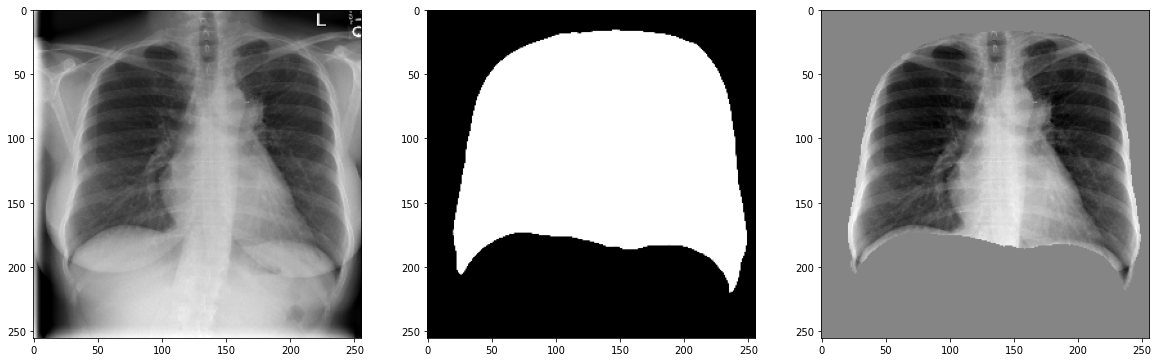

In [56]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = dice_model.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

# 3 canales

In [123]:
unet_model = keras.models.load_model('/home/mr1142/Documents/Data/models/unet_3chan_2.h5')

In [124]:
def apply_mask_3(img, mask):
    mask = mask[...,1]
    mask = cv2.blur(mask, (5,5))
    mask[mask>0.3]=1
    img[mask!=1]=0
    return img

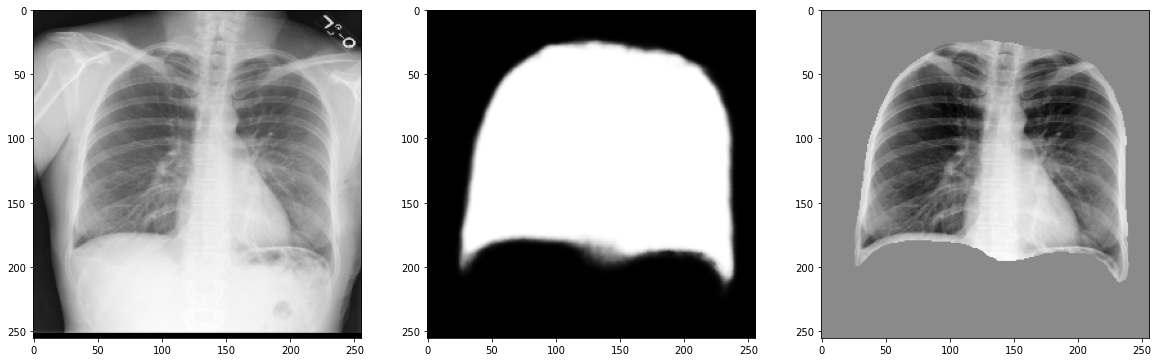

In [162]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask[...,1], cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask_3(img, mask), cmap = 'gray')
plt.show()

# Custom loss

In [16]:
import tensorflow as tf

In [17]:
masks_name = os.listdir('/home/mr1142/Documents/Data/segmentation/mascara')

In [18]:
def read_mask(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [19]:
mask = binarize(read_img('/home/mr1142/Documents/Data/segmentation/', 'mascara', masks_name[0]))

In [20]:
mask_model = keras.models.load_model('/home/mr1142/Documents/Data/models/mask_1.h5', 
                                     custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

In [21]:
sub_mask = tf.keras.Model(inputs=mask_model.input, outputs=mask_model.layers[18].output)

In [22]:
mask2 = sub_mask.predict(mask[np.newaxis,...])

In [23]:
unet_model = keras.models.load_model('/home/mr1142/Documents/Data/models/unet_custom_loss_2.h5', 
                                     custom_objects={"dice_coef_loss": dice_coef_loss, "dice_coef": dice_coef})

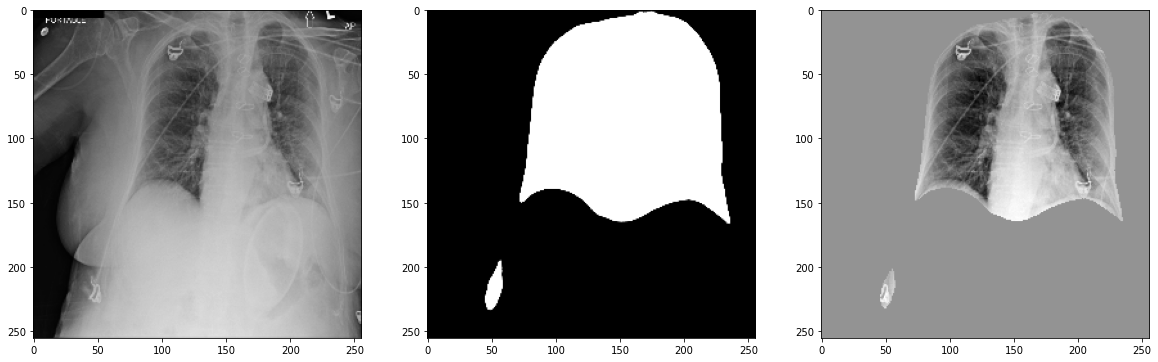

In [113]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict([img[np.newaxis,...], mask[np.newaxis,...], mask2])[1][0]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()

# Custom loss mejorada

In [9]:
import tensorflow as tf

In [10]:
masks_name = os.listdir('/home/mr1142/Documents/Data/segmentation/mascara')

In [13]:
def read_mask(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [14]:
def loss_mask(y_true, y_pred):
    y_pred = sub_mask(y_pred)
    y_true = sub_mask(y_true)
    return abs(y_true - y_pred)


def MyLoss(y_true, y_pred):
    # Loss 1
    loss1 = ex.dice_coef_loss(y_true, y_pred)
    # Loss 2
    loss2 = loss_mask(y_true, y_pred)
    loss = loss1 + 0.5*loss2
    return loss

In [97]:
unet_model = keras.models.load_model('/home/mr1142/Documents/Data/models/uloss_after_loss_correction_3.h5', 
                                     custom_objects={"MyLoss": MyLoss, "loss_mask": loss_mask, "dice_coef_loss": dice_coef_loss})

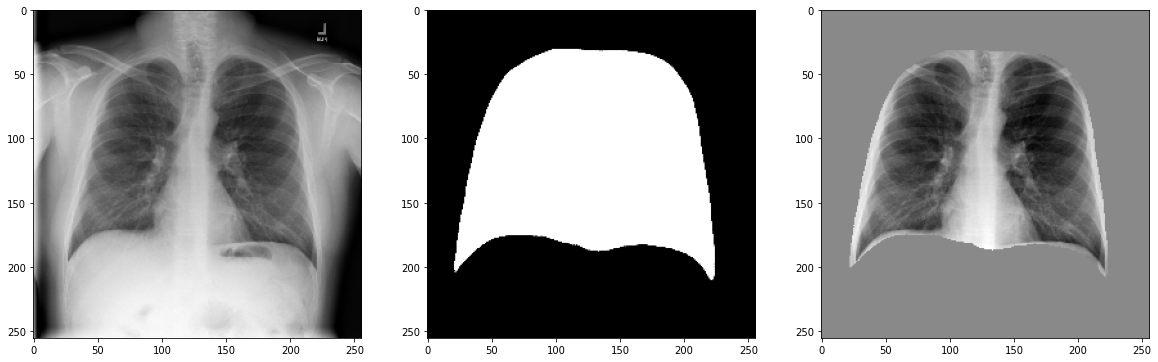

In [174]:
r = np.random.randint(0, len(val_names))
img = normalize(read_img(path, 'images', val_names[r]))
mask = unet_model.predict(img[np.newaxis,...])[0,...]
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(apply_mask(img, mask), cmap = 'gray')
plt.show()